### Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# (Optional) If you're working inside Jupyter
%load_ext autoreload
%autoreload 2
%matplotlib inline



In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:
input_data = pd.read_csv("TimesFM_120_diff_back_2019_2023_indexed.csv")

In [4]:
predicted_sced_rolled = input_data.drop(columns=["Unnamed: 0"])

In [5]:
predicted_sced_rolled

,sced_time_stamp_local,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,2019-01-09 00:00:00,14.904337,14.856879,14.804581,14.761519,14.778819,14.767986,14.697042,14.648296,14.603677,...,20.262610,20.251262,20.208018,20.219101,20.283101,20.308834,20.249483,20.285245,20.323103,17.548107
1,2019-01-09 00:05:00,16.700940,16.633303,16.552783,16.539977,16.485057,16.448075,16.377830,16.286241,16.192331,...,20.796301,20.808768,20.729427,20.741502,20.747866,20.807032,20.813069,20.859177,18.058918,18.171950
2,2019-01-09 00:10:00,16.860617,16.821205,16.750795,16.710409,16.603716,16.489484,16.343057,16.164306,16.023677,...,20.751538,20.761648,20.683613,20.678571,20.690357,20.763384,20.802035,18.019127,18.117165,18.195988
3,2019-01-09 00:15:00,17.061383,17.027316,16.938961,16.899389,16.796642,16.677356,16.539724,16.376566,15.635854,...,20.922010,20.943857,20.861746,20.876067,20.880247,21.009889,18.179311,18.338304,18.366046,18.415357
4,2019-01-09 00:20:00,16.994796,16.923139,16.833888,16.775172,16.650891,16.518467,16.334204,15.520318,15.389045,...,20.818167,20.808913,20.729105,20.736134,20.807780,18.053549,18.101379,18.236705,18.219182,18.236491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523459,2023-12-31 13:35:00,11.222120,11.153141,11.003985,10.964763,10.406114,10.207110,10.122366,10.052751,9.886682,...,13.816746,13.714600,14.073504,13.924111,13.868442,13.811270,13.811949,13.782185,13.784014,13.767509
523460,2023-12-31 13:40:00,11.770528,11.672510,11.502470,11.055708,10.909274,10.714954,10.629260,10.563797,10.411478,...,13.723091,14.102169,13.999665,13.864074,13.807491,13.759751,13.752017,13.694097,13.708409,13.705354
523461,2023-12-31 13:45:00,11.305088,11.230834,10.686852,10.664460,10.543890,10.363377,10.277418,10.237835,10.108693,...,13.724665,13.596064,13.484246,13.361971,13.285182,13.215150,13.192270,13.137895,13.171693,13.165281
523462,2023-12-31 13:50:00,11.442745,10.994086,10.868523,10.894435,10.836860,10.664034,10.598943,10.580885,10.466648,...,13.770382,13.712895,13.629581,13.556342,13.502110,13.415112,13.433148,13.413454,13.437855,13.356133


In [6]:
all_data = pd.read_csv("data_all_features_raw.csv")

In [7]:
all_data["net_load"] = all_data["Load_load"] - all_data["Fuel_solar"] - all_data["Fuel_wind"]

In [8]:
# Rename timestamp column for clarity
all_data = all_data.rename(columns={"Unnamed: 0": "timestamp"})
# Make sure the timestamp is in datetime format
all_data["timestamp"] = pd.to_datetime(all_data["timestamp"])

In [9]:

sced_data = all_data[["timestamp", 'SCED_system_lambda']]
hydro_data = all_data[["timestamp", 'Fuel_hydro']]
nuclear_data = all_data[["timestamp", "Fuel_nuclear"]]
storage_data = all_data[["timestamp", "Fuel_power_storage"]]
solar_data = all_data[["timestamp", "Fuel_solar"]]
wind_data = all_data[["timestamp", "Fuel_wind"]]
ng_data = all_data[["timestamp", "Fuel_natural_gas"]]
load_data = all_data[["timestamp", "Load_load"]]
net_load_data = all_data[["timestamp", "net_load"]]

In [10]:
import pandas as pd

def make_rolled_target(df, value_col, timestamp_col, look_ahead):
    """
    Creates a rolling look-ahead target DataFrame from a time series.
    
    Args:
        df (pd.DataFrame): Original DataFrame.
        value_col (str): Name of the column containing the values to roll.
        timestamp_col (str): Name of the timestamp column.
        look_ahead (int): Number of future steps to include.
    
    Returns:
        pd.DataFrame: A new DataFrame with 'timestamp' and look-ahead target columns.
    """
    
    # Create rolling horizon
    rolled = pd.DataFrame([
        pd.Series(df[value_col].iloc[i+1:i+1+look_ahead].values)
        for i in range(len(df) - look_ahead)
    ])
    rolled.columns = [f"{i+1}" for i in range(look_ahead)]
    
    # Add timestamp of starting point
    rolled["timestamp"] = df[timestamp_col].iloc[:len(rolled)].values
    
    # Reorder columns
    rolled = rolled[["timestamp"] + [col for col in rolled.columns if col != "timestamp"]]
    
    return rolled


In [11]:
look_ahead = 120  # or any value you choose
rolled_sced = make_rolled_target(sced_data, "SCED_system_lambda", "timestamp", look_ahead)
hydro_rolled = make_rolled_target(hydro_data, "Fuel_hydro", "timestamp", look_ahead)
nuclear_rolled = make_rolled_target(nuclear_data, "Fuel_nuclear", "timestamp", look_ahead)
storage_rolled = make_rolled_target(storage_data, "Fuel_power_storage", "timestamp", look_ahead)
solar_rolled = make_rolled_target(solar_data, "Fuel_solar", "timestamp", look_ahead)
wind_rolled = make_rolled_target(wind_data, "Fuel_wind", "timestamp", look_ahead)
ng_rolled = make_rolled_target(ng_data, "Fuel_natural_gas", "timestamp", look_ahead)
load_rolled = make_rolled_target(load_data, "Load_load", "timestamp", look_ahead)
net_load_rolled = make_rolled_target(net_load_data, "net_load", "timestamp", look_ahead)


In [12]:
dap_data = all_data[["timestamp", "DAP_SystemLambda"]]
rolled_dap = make_rolled_target(dap_data, "DAP_SystemLambda", "timestamp", look_ahead)

In [13]:
start_date = pd.Timestamp("2019-01-09 00:00:00")
end_date = pd.Timestamp("2023-12-31 13:55:00")

# For one DataFrame
rolled_sced = rolled_sced[(rolled_sced["timestamp"] >= start_date) & (rolled_sced["timestamp"] <= end_date)]
hydro_rolled = hydro_rolled[(hydro_rolled["timestamp"] >= start_date) & (hydro_rolled["timestamp"] <= end_date)]
nuclear_rolled = nuclear_rolled[(nuclear_rolled["timestamp"] >= start_date) & (nuclear_rolled["timestamp"] <= end_date)]
storage_rolled = storage_rolled[(storage_rolled["timestamp"] >= start_date) & (storage_rolled["timestamp"] <= end_date)]
solar_rolled = solar_rolled[(solar_rolled["timestamp"] >= start_date) & (solar_rolled["timestamp"] <= end_date)]
wind_rolled = wind_rolled[(wind_rolled["timestamp"] >= start_date) & (wind_rolled["timestamp"] <= end_date)]
ng_rolled = ng_rolled[(ng_rolled["timestamp"] >= start_date) & (ng_rolled["timestamp"] <= end_date)]
load_rolled = load_rolled[(load_rolled["timestamp"] >= start_date) & (load_rolled["timestamp"] <= end_date)]
net_load_rolled = net_load_rolled[(net_load_rolled["timestamp"] >= start_date) & (net_load_rolled["timestamp"] <= end_date)]


In [14]:
net_load_rolled

,timestamp,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
2304,2019-01-09 00:00:00,23883.748420,23825.748420,23831.212816,23773.212816,23715.212816,23830.756908,23772.756908,23714.756908,23711.375816,...,35678.809268,35638.809268,35599.809268,35479.385748,35439.385748,35400.385748,35360.580136,35321.580136,35281.580136,35241.169012
2305,2019-01-09 00:05:00,23825.748420,23831.212816,23773.212816,23715.212816,23830.756908,23772.756908,23714.756908,23711.375816,23654.375816,...,35638.809268,35599.809268,35479.385748,35439.385748,35400.385748,35360.580136,35321.580136,35281.580136,35241.169012,35176.169012
2306,2019-01-09 00:10:00,23831.212816,23773.212816,23715.212816,23830.756908,23772.756908,23714.756908,23711.375816,23654.375816,23596.375816,...,35599.809268,35479.385748,35439.385748,35400.385748,35360.580136,35321.580136,35281.580136,35241.169012,35176.169012,35111.169012
2307,2019-01-09 00:15:00,23773.212816,23715.212816,23830.756908,23772.756908,23714.756908,23711.375816,23654.375816,23596.375816,23531.469856,...,35479.385748,35439.385748,35400.385748,35360.580136,35321.580136,35281.580136,35241.169012,35176.169012,35111.169012,34757.934196
2308,2019-01-09 00:20:00,23715.212816,23830.756908,23772.756908,23714.756908,23711.375816,23654.375816,23596.375816,23531.469856,23523.469856,...,35439.385748,35400.385748,35360.580136,35321.580136,35281.580136,35241.169012,35176.169012,35111.169012,34757.934196,34691.934196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525763,2023-12-31 13:35:00,22071.600000,22069.900000,21587.900000,21801.800000,21716.000000,21532.900000,21285.300000,21276.800000,21331.800000,...,24927.200000,24929.900000,25088.100000,25272.300000,25426.400000,25605.200000,25734.300000,25973.600000,26008.600000,26185.300000
525764,2023-12-31 13:40:00,22069.900000,21587.900000,21801.800000,21716.000000,21532.900000,21285.300000,21276.800000,21331.800000,21575.000000,...,24929.900000,25088.100000,25272.300000,25426.400000,25605.200000,25734.300000,25973.600000,26008.600000,26185.300000,25814.100000
525765,2023-12-31 13:45:00,21587.900000,21801.800000,21716.000000,21532.900000,21285.300000,21276.800000,21331.800000,21575.000000,21548.000000,...,25088.100000,25272.300000,25426.400000,25605.200000,25734.300000,25973.600000,26008.600000,26185.300000,25814.100000,25954.100000
525766,2023-12-31 13:50:00,21801.800000,21716.000000,21532.900000,21285.300000,21276.800000,21331.800000,21575.000000,21548.000000,20814.000000,...,25272.300000,25426.400000,25605.200000,25734.300000,25973.600000,26008.600000,26185.300000,25814.100000,25954.100000,25927.300000


In [15]:
import pandas as pd
import numpy as np

# ---- Step 1: Load and Preprocess ----
# (Assume you already have your rolling window dataframes like hydro_rolled, wind_rolled, sced_rolled, etc.)

# Define the list of all input feature rolled DataFrames
input_feature_rolled_list = [
    solar_rolled,
    wind_rolled,
    ng_rolled,
    net_load_rolled,
    predicted_sced_rolled,
]

# ---- Step 2: Build Input Tensor X ----
# For each feature, extract the future window columns ('1' to '120')
X_list = []

for df in input_feature_rolled_list:
    X_feature = df[[str(i) for i in range(1, 121)]].values  # (N, 120)
    X_list.append(X_feature)

# Stack features together
X = np.stack(X_list, axis=-1)  # final shape (N, 120, num_features)

# ---- Step 3: Build Target Tensor y ----
y = rolled_sced[[str(i) for i in range(1, 121)]].values  # (N, 10)

# ---- Step 4: Store timestamps separately ----
timestamps = pd.to_datetime(rolled_sced["timestamp"].values[:len(X)])  # (N,)

# ---- Step 5: Define Time Ranges ----
train_start = pd.Timestamp("2019-01-09 00:00:00")
train_end = pd.Timestamp("2021-12-31 23:55:00")
eval_start = pd.Timestamp("2022-01-01 00:00:00")
eval_end = pd.Timestamp("2022-12-31 23:55:00")
test_start = pd.Timestamp("2023-01-01 00:00:00")
test_end = pd.Timestamp("2023-12-31 13:55:00")

# ---- Step 6: Create Masks ----
train_mask = (timestamps >= train_start) & (timestamps <= train_end)
eval_mask = (timestamps >= eval_start) & (timestamps <= eval_end)
test_mask = (timestamps >= test_start) 

# ---- Step 7: Split into Train/Eval/Test ----
X_train, y_train, ts_train = X[train_mask], y[train_mask], timestamps[train_mask]
X_eval, y_eval, ts_eval = X[eval_mask], y[eval_mask], timestamps[eval_mask]
X_test, y_test, ts_test = X[test_mask], y[test_mask], timestamps[test_mask]

# ---- Step 8: (Optional) Check final shapes ----
print(f"Train X: {X_train.shape}, y: {y_train.shape}")
print(f"Eval X: {X_eval.shape}, y: {y_eval.shape}")
print(f"Test X: {X_test.shape}, y: {y_test.shape}")


Train X: (313344, 120, 5), y: (313344, 120)
Eval X: (105120, 120, 5), y: (105120, 120)
Test X: (105000, 120, 5), y: (105000, 120)


# Normalization

In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def standardize_rolled_inputs(X_train, X_eval, X_test):
    """
    Standardizes 3D input arrays (N, T, F) by flattening across time,
    fitting scaler only on training set, and applying it consistently.
    """
    N_train, T, F = X_train.shape

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, F)
    scaler.fit(X_train_flat)

    # Transform and reshape back
    X_train_scaled = scaler.transform(X_train_flat).reshape(N_train, T, F)
    X_eval_scaled = scaler.transform(X_eval.reshape(-1, F)).reshape(X_eval.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape)

    return X_train_scaled, X_eval_scaled, X_test_scaled, scaler


In [17]:
X_train_scaled, X_eval_scaled, X_test_scaled, scaler = standardize_rolled_inputs(
    X_train, X_eval, X_test
)

In [18]:
X_train_mlp = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_eval_mlp = X_eval_scaled.reshape(X_eval_scaled.shape[0], -1)
X_test_mlp = X_test_scaled.reshape(X_test_scaled.shape[0], -1)


# Model Building

In [23]:
from MLP import MLPModel

new_model = MLPModel(
    input_shape=X_train_scaled.shape[2],
    output_shape=y_train.shape[1],
    hidden_layers=[512, 512, 512]
)

mlp_model = new_model.get_model()

# Send model to device
mlp_model.to(device)


MLPModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=120, bias=True)
  )
)

In [24]:
from ModelTrainer import ModelTrainer
from losses import fluctuation_loss  # or define it above in your notebook

trainer = ModelTrainer(
    model=mlp_model,
    features_training_data=X_train_scaled,
    target_training_data=y_train,
    features_eval_data=X_eval_scaled,
    target_eval_data=y_eval,
    device=device,
    loss_fn=lambda pred, target: fluctuation_loss(pred, target, alpha=0.2)
)


trainer.train(epochs=100, batch_size=32, patience=50, learning_rate=5e-4)


torch.Size([3840, 5])
torch.Size([3840, 120])


RuntimeError: The size of tensor a (120) must match the size of tensor b (32) at non-singleton dimension 1

In [ ]:
# predict

mlp_model.eval()
with torch.no_grad():
    y_pred = mlp_model(torch.tensor(X_test_mlp, dtype=torch.float32).to(device))


y_pred = y_pred.cpu().numpy()
errors = y_pred - y_test  # assuming y_test is numpy array
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(errors))

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")



Test MAE: 48.6533
Test RMSE: 256.4127


In [ ]:
# Recreate test_mask using rolled_dap's timestamps
dap_timestamps = pd.to_datetime(rolled_dap["timestamp"])
test_start = pd.Timestamp("2023-01-01 00:00:00")
test_mask_dap = dap_timestamps >= test_start

# Then apply it to dap_test
dap_test = rolled_dap[[str(i) for i in range(1, 121)]].values
dap_test = dap_test[test_mask_dap]


In [ ]:
dap_test

array([[10.8334, 10.8334, 10.8334, ..., 15.0522, 15.0522, 17.2491],
       [10.8334, 10.8334, 10.8334, ..., 15.0522, 17.2491, 17.2491],
       [10.8334, 10.8334, 10.8334, ..., 17.2491, 17.2491, 17.2491],
       ...,
       [14.4612, 14.4612, 13.861 , ..., 19.2456, 19.2456, 19.2456],
       [14.4612, 13.861 , 13.861 , ..., 19.2456, 19.2456, 19.2456],
       [13.861 , 13.861 , 13.861 , ..., 19.2456, 19.2456, 19.2456]])

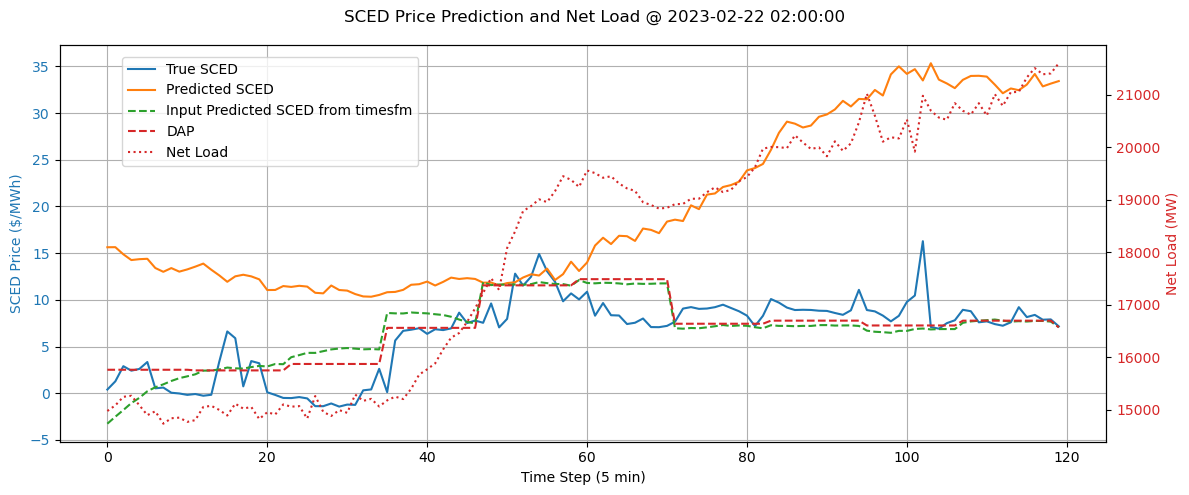

In [ ]:
import matplotlib.pyplot as plt

idx =15000  # sample index to visualize

# Main data (prices)
timestamp = ts_test[idx]
true_sced = y_test[idx]
pred_sced = y_pred[idx]
dap_window = dap_test[idx]
input_pred_sced = X_test[idx, :, 4]

# Secondary data (net load)
net_load = X_test[idx, :, 3]  # assuming net_load is the 4th feature (index 3)
solar_load = X_test[idx, :, 0]  # assuming net_load is the 4th feature (index 3)
wind_load = X_test[idx, :, 1]  # assuming net_load is the 4th feature (index 3)

# ---- Plotting ----
fig, ax1 = plt.subplots(figsize=(12, 5))

# Left y-axis: SCED prices
ax1.plot(true_sced, label="True SCED", color="tab:blue")
ax1.plot(pred_sced, label="Predicted SCED", color="tab:orange")
ax1.plot(input_pred_sced, label="Input Predicted SCED from timesfm", color="tab:green", linestyle="--")
ax1.plot(dap_window, label="DAP", color="tab:red", linestyle="--")
ax1.set_xlabel("Time Step (5 min)")
ax1.set_ylabel("SCED Price ($/MWh)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(True)

# Right y-axis: Net Load
ax2 = ax1.twinx()
ax2.plot(net_load, label="Net Load", color="tab:red", linestyle=":")
ax2.set_ylabel("Net Load (MW)", color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

# ---- Title and Legend ----
fig.suptitle(f"SCED Price Prediction and Net Load @ {timestamp}")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()


### Optimizing

In [ ]:
len(dap_test)

105288

In [ ]:
# add timestamp to the predictions
# Use appropriate timestamps from your DataFrame (e.g., 5-minute intervals)
timestamps = pd.date_range(
    start="2023-01-01 00:00:00",
    periods=105000,
    freq="5min"
)

# Columns are step 1, step 2, ..., step 10
columns = [f"step_{i+1}" for i in range(y_pred.shape[1])]

# Build DataFrame
sl_pred = pd.DataFrame(dap_test, columns=columns)
sl_pred["timestamps"] = timestamps
# Reorder to put "timestamps" first
sl_pred = sl_pred[["timestamps"] + [col for col in sl_pred.columns if col != "timestamps"]]



# Save to CSV files
sl_pred.to_csv('5min_dap_241h.csv')

ValueError: Length of values (105000) does not match length of index (105288)

In [ ]:
sl_pred

,timestamps,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,...,step_111,step_112,step_113,step_114,step_115,step_116,step_117,step_118,step_119,step_120
0,2023-01-01 00:00:00,11.620060,11.486585,11.148252,10.910307,10.643177,10.356711,10.128198,9.957698,9.773606,...,9.349919,9.236627,9.459879,9.620667,9.502387,9.599428,9.747838,9.970437,10.140862,10.322237
1,2023-01-01 00:05:00,11.573868,11.435232,11.090905,10.861153,10.599686,10.315523,10.085863,9.907683,9.731329,...,9.101844,9.010810,9.228674,9.388186,9.293757,9.392380,9.535870,9.754105,9.918662,10.095756
2,2023-01-01 00:10:00,11.531981,11.388666,11.038904,10.816581,10.560248,10.278175,10.047475,9.862332,9.692993,...,8.876897,8.806046,9.019024,9.177378,9.104579,9.204635,9.343663,9.557940,9.717177,9.890389
3,2023-01-01 00:15:00,11.423599,11.268177,10.904350,10.701251,10.458205,10.181537,9.948144,9.744986,9.593799,...,8.294839,8.276212,8.476548,8.631907,8.615072,8.718840,8.846325,9.050359,9.195829,9.358998
4,2023-01-01 00:20:00,11.338832,11.173941,10.799113,10.611050,10.378395,10.105953,9.870456,9.653207,9.516217,...,7.839603,7.861822,8.052270,8.205286,8.232224,8.338892,8.457349,8.653372,8.788075,8.943390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,2023-12-31 13:35:00,18.689415,19.345669,19.924725,18.432884,17.299109,16.660135,16.607170,17.611818,16.243710,...,47.315418,43.795727,44.843571,45.199749,41.431072,41.286076,42.187450,43.078098,44.146496,44.982941
104996,2023-12-31 13:40:00,18.464947,19.096125,19.646049,18.194025,17.087769,16.459988,16.401447,17.368782,16.038269,...,46.109928,42.698399,43.720058,44.070034,40.417263,40.279953,41.157417,42.026855,43.066738,43.882385
104997,2023-12-31 13:45:00,18.287796,18.899185,19.426121,18.005518,16.920979,16.302031,16.239092,17.176979,15.876135,...,45.158554,41.832386,42.833385,43.178459,39.617168,39.485920,40.344517,41.197212,42.214596,43.013828
104998,2023-12-31 13:50:00,18.115610,18.707764,19.212357,17.822292,16.758862,16.148500,16.081285,16.990551,15.718545,...,44.233841,40.990639,41.971554,42.311874,38.839493,38.714138,39.554398,40.390820,41.386330,42.169609


In [ ]:
print(sl_pred)

                            0          1          2          3          4   \
2023-01-01 23:55:00  -0.943643  -1.510712  -2.383256  -1.734692   1.032408   
2023-01-02 00:00:00  -1.579532  -2.412360  -4.080081  -3.691894  -0.212925   
2023-01-02 00:05:00  -1.952366  -2.048961  -4.300113  -2.235637  -0.612865   
2023-01-02 00:10:00  -1.642491  -1.067345  -3.787768  -1.397984   0.443273   
2023-01-02 00:15:00  -2.357398  -1.111841  -4.189584  -1.638471  -0.474079   
...                        ...        ...        ...        ...        ...   
2023-12-31 15:35:00  13.642232  14.620449  14.273226  14.796878  14.870831   
2023-12-31 15:40:00  14.024353  14.647687  14.478355  14.952069  15.014936   
2023-12-31 15:45:00  14.471080  15.430356  15.126199  15.246523  15.342616   
2023-12-31 15:50:00  13.736179  14.549651  14.506347  13.951535  14.495383   
2023-12-31 15:55:00  13.665600  13.867071  14.219832  13.984599  14.115159   

                            5          6          7          8 

In [ ]:
pred_df = sl_pred.copy()

In [ ]:
# prepare the nodal real-time price in the required shape
actual = pd.read_csv('lmp_WAKEWE_ALL_2023.csv')
actual_rolled = pd.DataFrame([pd.Series(actual['price'].iloc[i+1:i+1+look_ahead].values) for i in range(len(actual) - look_ahead)])
actual_rolled.columns = [f'{i+1}' for i in range(look_ahead)]
actual_rolled['timestamp'] = actual['timestamp'].iloc[:len(actual_rolled)].values
actual_rolled = actual_rolled[['timestamp'] + [col for col in actual_rolled.columns if col != 'timestamp']]
actual_rolled = actual_rolled.iloc[:,:look_ahead+1]

In [ ]:
actual_rolled

,timestamp,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,1/1/23 0:00,-2.65,-2.39,-2.35,-2.34,-2.33,-2.33,-2.02,-1.54,-1.69,...,2.86,2.74,2.78,9.25,9.13,9.12,9.26,11.77,19.33,20.83
1,1/1/23 0:05,-2.39,-2.35,-2.34,-2.33,-2.33,-2.02,-1.54,-1.69,-1.69,...,2.74,2.78,9.25,9.13,9.12,9.26,11.77,19.33,20.83,20.21
2,1/1/23 0:10,-2.35,-2.34,-2.33,-2.33,-2.02,-1.54,-1.69,-1.69,-1.53,...,2.78,9.25,9.13,9.12,9.26,11.77,19.33,20.83,20.21,19.53
3,1/1/23 0:15,-2.34,-2.33,-2.33,-2.02,-1.54,-1.69,-1.69,-1.53,-1.53,...,9.25,9.13,9.12,9.26,11.77,19.33,20.83,20.21,19.53,23.22
4,1/1/23 0:20,-2.33,-2.33,-2.02,-1.54,-1.69,-1.69,-1.53,-1.53,-1.53,...,9.13,9.12,9.26,11.77,19.33,20.83,20.21,19.53,23.22,24.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,12/31/23 13:35,12.29,11.97,11.28,11.78,11.75,11.19,8.19,8.97,10.76,...,14.07,13.84,14.19,14.40,14.44,14.87,14.76,14.48,14.73,14.82
104996,12/31/23 13:40,11.97,11.28,11.78,11.75,11.19,8.19,8.97,10.76,11.24,...,13.84,14.19,14.40,14.44,14.87,14.76,14.48,14.73,14.82,14.54
104997,12/31/23 13:45,11.28,11.78,11.75,11.19,8.19,8.97,10.76,11.24,10.47,...,14.19,14.40,14.44,14.87,14.76,14.48,14.73,14.82,14.54,14.47
104998,12/31/23 13:50,11.78,11.75,11.19,8.19,8.97,10.76,11.24,10.47,7.73,...,14.40,14.44,14.87,14.76,14.48,14.73,14.82,14.54,14.47,14.39


In [ ]:
# Storage parameters
bid_ahead = 1
horizon = int(look_ahead/12) - bid_ahead #in hours

Ts = 1/12  # hourly time step. If the price data is 5-min; Ts = 1/12. If it is hourly; Ts = 1
hr = int(1 / Ts)  # number of time steps in one hour

# Parameters
E = 1  # Energy rating in MWh
Pr = 1 / 2  # normalized power rating wrt energy rating
P = Pr * Ts  # actual power rating taking time step size into account
eta = 0.9  # efficiency
c = 10  # marginal discharge cost - degradation
initial_soc = 0.5

T = hr * horizon #the horizon as number of steps
T = int(T)  # force conversion to native Python int


In [ ]:
print(T, type(T))


108 <class 'int'>


In [ ]:
import cvxpy as cp
# optimization model
result_dfs = []

eS = np.zeros(T)  # initialize the SoC series
profit = np.zeros(T)  # initialize the profit series
revenue = np.zeros(T)  # initialize the revenue series

soc_var = cp.Variable(T, nonneg=True)
chr_var = cp.Variable(T, nonneg=True)
dis_var = cp.Variable(T, nonneg=True)
charge_decision = cp.Variable(T, boolean=True)
discharge_decision = cp.Variable(T, boolean=True)
discharge_active = cp.Variable(T, boolean=True)
M = 1e6  # A large constant
price_param = cp.Parameter(T)
soc_init_param = cp.Parameter()

cons = [
    soc_var[0] - soc_init_param == chr_var[0] * eta - dis_var[0] / eta,
    *[soc_var[i] - soc_var[i-1] == chr_var[i] * eta - dis_var[i] / eta for i in range(1, T)],
    *[chr_var[i] <= P for i in range(T)],
    *[soc_var[i] <= E for i in range(T)],
    *[charge_decision[i] + discharge_decision[i] <= 1 for i in range(T)],
    *[dis_var[i] <= discharge_active[i] * P for i in range(T)],
    *[dis_var[i] >= 0 for i in range(T)],
    *[price_param[i] >= -M * (1 - discharge_active[i]) for i in range(T)],
    *[price_param[i] <= M * discharge_active[i] for i in range(T)]
]

revenue_obj = cp.multiply(price_param, (dis_var - chr_var)) - c * dis_var
problem = cp.Problem(cp.Maximize(cp.sum(revenue_obj)), cons)


for start in tqdm(range(int(len(actual_rolled)-bid_ahead*12))):
    slice_actual = actual_rolled.iloc[start+bid_ahead*12, :T+1]
    slice_pred = pred_df.iloc[start, 1+bid_ahead*12:T+bid_ahead*12+1].copy()
    slice_pred.iloc[0] = slice_actual[1]  # Replace the first item with actual_rolled's first item

    price_param.value = slice_pred.values.astype(float)
    soc_init_param.value = initial_soc
    problem.solve(solver=cp.GLPK_MI)
    pS_dis = dis_var.value
    pS_chr = chr_var.value
    eS = soc_var.value
    revenue = slice_actual.iloc[1:].values.astype(float) * (pS_dis - pS_chr)
    profit = revenue - c * pS_dis
    storage_profile_sl = pd.Series({
        'time': slice_actual.iloc[0],
        'actual': slice_actual.iloc[1],
        'pred': slice_pred.iloc[0],
        'discharge': pS_dis[0],
        'charge': pS_chr[0],
        'soc': eS[0],
        'profit': profit[0],
        'revenue': revenue[0]})
    result_dfs.append(storage_profile_sl)
    initial_soc = eS[0]

final_result_lmp = pd.DataFrame(result_dfs)

final_result_lmp.to_csv(str(bid_ahead)+'hr_bidding_results'+str(T)+'_lmp_5min_TimesFM_sced.csv', index=False)



AttributeError: module 'numpy._core.multiarray' has no attribute 'ndarray'

In [ ]:
final_result_lmp.profit.sum()

In [ ]:
sl_pred_reset = sl_pred.reset_index()

In [ ]:
print(optimizer.sced.shape)

(104737, 96)


In [ ]:
print(optimizer.sced_reset.shape)

(104737, 97)


In [ ]:
optimizer.slice_lmp_replace_sced()
print(optimizer.sced_reset.shape, sl_pred_reset.shape)

/insomnia001/home/hl3837/research/code/utils/storage_optimizer.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lmp_data = pd.read_csv('../../datasset/lmp_WAKEWE_ALL_2023.csv', parse_dates=[0], index_col=0)


(104737, 97) (104737, 97)


# Storage Arbitrage
Perform storage arbitrage for WAKEWE_ALL node. Use the predicted system lambda to derive the best decisions to maximize profit.
The test year is 2023, so we need the nodal real-time price for that year.

In [ ]:
optimizer = StorageOptimizer(8)
optimizer.set_prediction_file(sl_pred) #"../../models/MLP/5min_sl_pred_dap_241h.csv"
#optimizer.slice_lmp_replace_sced()
final_result = optimizer.optimize()

sced shape is:  (104737, 97)
sced reset shape is:  (104737, 97)


In [ ]:
final_result.profit.sum()

np.float64(39730.464393017995)

In [ ]:
optimizer2 = StorageOptimizer(1)
optimizer2.set_prediction_file("../../models/MLP/5min_sl_actual_dap_241h.csv")
final_result2 = optimizer2.optimize()

100%|██████████| 104820/104820 [06:55<00:00, 252.55it/s]


In [ ]:
final_result2.profit.sum()

np.float64(58403.2749058563)